# Predecting if patients will miss their scheduled appointments or not.

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

> This dataset collects information from 100k medical appointments in Brazil and is focused on the question of whether or not patients show up for their appointment.

> Description of all features and the data itself is [here](https://www.kaggle.com/datasets/joniarroba/noshowappointments)

> Some of them:
* ‘ScheduledDay’ tells us on what day the patient set up their appointment.
* ‘Neighborhood’ indicates the location of the hospital.
* ‘Scholarship’ indicates whether or not the patient is enrolled in Brasilian welfare program Bolsa Família.  
* Be careful about the encoding of the last column: it says ‘No’ if the patient showed up to their appointment, and ‘Yes’ if they did not show up.

### Questions for Analysis we need to answer.
* What factors are important for us to know in order to predict if a patient will show up for their scheduled appointment?

1. What are the most **days** for showing up and No-showing up?
2. Is the increase in the number of **waiting days** affect the showing up?
3. Is there any relationship between showing up and **gender**?
4. Is there any relationship between showing up and the **age**?
5. Does **receiving SMS messages** have an effect on coming to the appointment?


5. What is the relationship between **Hipertension**, **Diabetes**, **Alcoholism**, **Handcap**, **Scholarship**, and the **showing up**?
6. What are the **best 5 hospitals** with the maximum propotion of showing up?



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
df = pd.read_csv('KaggleV2-May-2016.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [177]:
def PlotBars(label1, height1, label2, height2, col1='r', col2='b', Titel='Titel', yLabel='Number of patients', xLabel=''):
    sns.set()
    fig, ax = plt.subplots()
    ax.bar(label1, height1, label=label1, color=col1)
    ax.bar(label2, height2, label=label2, color=col2)
    ax.set_title(Titel, fontweight='bold')
    ax.set_ylabel(yLabel)
    ax.set_xlabel(xLabel)
    ax.legend()
    
def PlotPies(column, Labels, Title):
    sns.set()
    fig = plt.figure(figsize =(10, 7))
    plt.pie(df[column].value_counts().values, labels=Labels, colors=['#234E70', 'r'], autopct='%.0f%%', textprops={'color':"w"})
    plt.legend()
    plt.title(Title)
    plt.show()
    

def get_propotions(column_name, DataFrame):
    """
        SUMMERY:
            TO GIVE PROPOTIONS OF THE VALUES IN THE COLUMNS.
        TAKE:
            column_name: (str) for the column we need to get propotions on it.
            DataFrame: (DataFrame) for the data frame we need to make propotions on it.
        RETURN:
            propotions
     """ 
    
    #For the total counts of the categories in column which have categories on it like in 
    #   Gender > getting count of all Females & count of all Males
    #   Age_stage > getting count of all each Age Stage.
    
    TotalValues_forEachCategory = DataFrame.groupby([column_name])['No_show'].count()
    
    # Getting the count of all who show up for each category and count of all who didn't in each category.
    valuesFor_Show_noShow = DataFrame.groupby([column_name, 'No_show'])['No_show'].count()
    
    # To be fair we not use ValuesFor_Show_noShow but we divide it by the TotalValues
    # as our data have different number of rows for each category .. so to be fair we divide each 
    # count of patients who showed up in category X by the total number of patients in this category.
    propotions = valuesFor_Show_noShow / TotalValues_forEachCategory
    
    return propotions


def PlotPropotions(propotions, column_name, color1, color2, xLabel_1, xLabel_2):
    # Propotions come from get_propotion function.
    propotions.unstack().plot(kind='bar', color=[color1, color2]);
    plt.ylabel('Avg num of patients')
    plt.xlabel('');
    plt.title(f'{column_name} & No-show', fontsize=15, fontweight='bold')
    plt.legend(labels=['Showed up', 'Did not show up'], fontsize=14, bbox_to_anchor=(1.05, 0.7));
    plt.xticks([0, 1], [xLabel_1, xLabel_2], rotation=0);

<a id='wrangling'></a>
## Data Wrangling


### Assessing and Building Intuition

In [3]:
df.shape

(110527, 14)

There are 14 columns and 110527 rows in the dataset.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


> * ScheduledDay & AppointmentDay are objects not DayTime.
> * No-show column's data types need to be integers to help us make statistic operations on it.

In [5]:
# This shows the number of unique values in each column.
df.nunique()

PatientId          62299
AppointmentID     110527
Gender                 2
ScheduledDay      103549
AppointmentDay        27
Age                  104
Neighbourhood         81
Scholarship            2
Hipertension           2
Diabetes               2
Alcoholism             2
Handcap                5
SMS_received           2
No-show                2
dtype: int64

> * The number of unique appointments > patients .. thats mean many patients have more than one appointment.
>
> * There are 5 values in Handcap column, but it should be only 0 & 1.

In [6]:
# The Descriptive statistics for each column.
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


> * Avg age of the patients is 37 years old.
> * The oldest patient has 115 years old.
> * There are not many patients have Diabetes, Alcoholism or Handcap.
> * Less than the half of the sms messages are received.

In [7]:
# Number of null values.
df.isnull().sum().sum()

0

There is no null values in the dataset.

> Info about **Age** column.

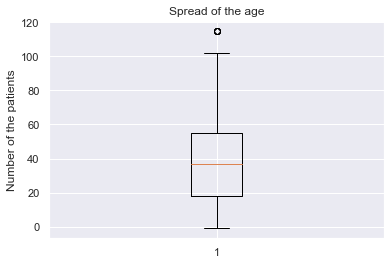

In [8]:
# Getting statistical informations about age column.
sns.set()
fig, ax = plt.subplots()
ax.boxplot(df['Age']);
ax.set_title('Spread of the age');
ax.set_ylabel('Number of the patients');

* There is an outlier when the patient has about 119 years old.

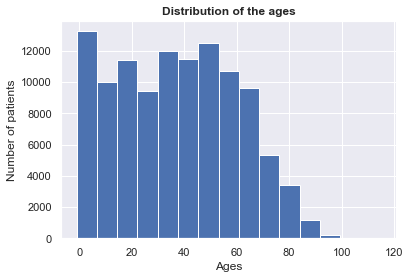

In [9]:
fig, ax = plt.subplots()
ax.hist(df['Age'], bins=15)
ax.set_xlabel("Ages")
ax.set_title('Distribution of the ages', fontweight='bold');
ax.set_ylabel('Number of patients');

* The age state that has the maximum number of patients is Infants.
* We will classify the ages by groups.

> Info about **Gender** column.

In [10]:
Data = df['Gender'].value_counts()
Data

F    71840
M    38687
Name: Gender, dtype: int64

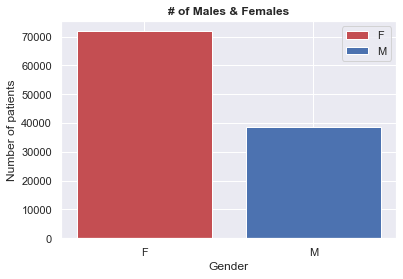

In [11]:
PlotBars(label1=Data.index[0], height1=Data.values[0], label2=Data.index[1], height2=Data.values[1], Titel='# of Males & Females', xLabel='Gender')

* There are more than 70,000 female patients.
* There are less than 40,000 male patients.
* There are a number of female patients about double the number of the male patients

Text(0, 0.5, 'Number of appointments')

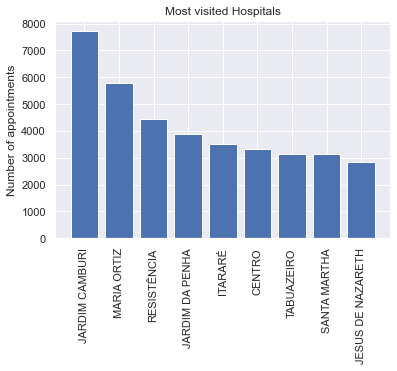

In [12]:
most_visited_hospitals = df.Neighbourhood.value_counts()[0: 9]
names = most_visited_hospitals.index
sns.set()
fig, ax = plt.subplots()
ax.bar(most_visited_hospitals.index, most_visited_hospitals.values);
plt.xticks(rotation=90);
ax.set_title('Most visited Hospitals')
ax.set_ylabel('Number of appointments')

> Info about **Scholarship** column.

In [13]:
Data = df['Scholarship'].value_counts()
Data

0    99666
1    10861
Name: Scholarship, dtype: int64

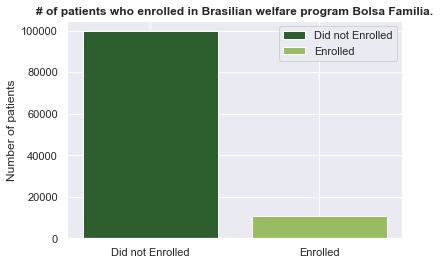

In [14]:
PlotBars(label1='Did not Enrolled', height1=Data.values[0], label2='Enrolled', height2=Data.values[1], Titel="# of patients who enrolled in Brasilian welfare program Bolsa Família.", col1='#2C5F2D', col2='#97BC62FF')

* There are about 100,000 patients who did not enrolled the Brasilian welfare praogram Bolsa Familia.
* There are about 10,000  patients who enrolled.

> Info about **Hipertension** column.

In [15]:
Data = df['Hipertension'].value_counts()
Data

0    88726
1    21801
Name: Hipertension, dtype: int64

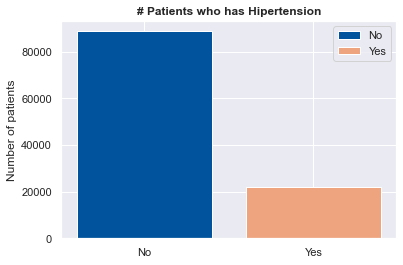

In [16]:
PlotBars(label1='No', height1=Data.values[0], label2='Yes', height2=Data.values[1], Titel="# Patients who has Hipertension", col1='#00539CFF', col2='#EEA47FFF')

* Most of patients does not have Hipertension.

> Info about **Diabetes** column.

In [17]:
Data = df['Diabetes'].value_counts()
Data

0    102584
1      7943
Name: Diabetes, dtype: int64

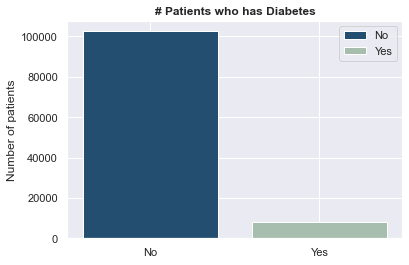

In [18]:
PlotBars(label1='No', height1=Data.values[0], label2='Yes', height2=Data.values[1], Titel="# Patients who has Diabetes", col1='#234E70', col2='#A7BEAE')

* About 102,000 patients do not have diabetes.
* Less than 10,000 patients do.

> Info about **Alcoholism** column.

In [19]:
Data = df['Alcoholism'].value_counts()
Data

0    107167
1      3360
Name: Alcoholism, dtype: int64

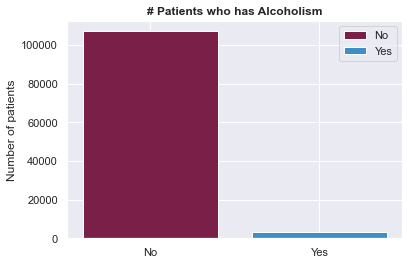

In [20]:
PlotBars(label1='No', height1=Data.values[0], label2='Yes', height2=Data.values[1], Titel="# Patients who has Alcoholism", col1='#7A2048', col2='#408EC6')

* About 107,000 patients do not have Alcoholism.
* Less than 3,500 patients do.

> Info about **SMS_received** column.

In [21]:
Data = df['SMS_received'].value_counts()
Data

0    75045
1    35482
Name: SMS_received, dtype: int64

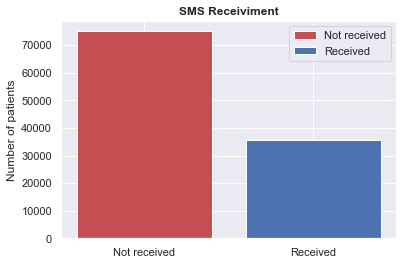

In [22]:
PlotBars(label1='Not received', height1=Data.values[0], label2='Received', height2=Data.values[1], Titel="SMS Receiviment")

> * More than 75,000 sms messages did not recieved.
> * About 35,000 sms messages recieved.

In [23]:
Data = df['No-show'].value_counts()
Data

No     88208
Yes    22319
Name: No-show, dtype: int64

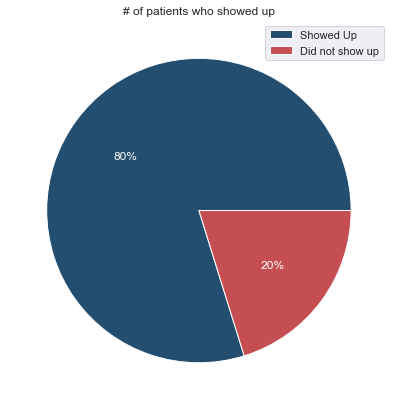

In [24]:
PlotPies(column='No-show', Labels=['Showed Up', 'Did not show up'], Title='# of patients who showed up')

* There are 80% of patients showed up.


### Data Cleaning

> Cleaning and Editing **ScheduledDay & AppointmentDay** columns.

In [25]:
# Making the data type of ScheduledDay & AppointmentDay => DateTime data type.

# converting column from object -> datetime
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])

df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])

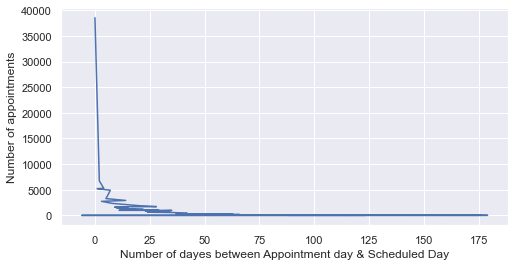

In [26]:
# calculating the difference between the 2 days using only dates not hours.
Waiting = df['AppointmentDay'].dt.date - df['ScheduledDay'].dt.date
Waiting = Waiting.dt.days

# To inserting them in the first columns not to change the No-how column's position.
df.insert(5, 'Waiting', Waiting)

df.Waiting.value_counts().plot(figsize=(8, 4));
plt.xlabel('Number of dayes between Appointment day & Scheduled Day', fontsize=12);
plt.ylabel('Number of appointments', fontsize=12);

* Most appointments are token on their scheduled days but there are few appointments that are token after the scheduled day and before it! so we need to handle that.
* So, we need to delete all rows of appointment days befor their scheduled days!

In [27]:
df.head(1)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Waiting,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,0,62,JARDIM DA PENHA,0,1,0,0,0,0,No


In [28]:
df = df.query('Waiting >= 0')

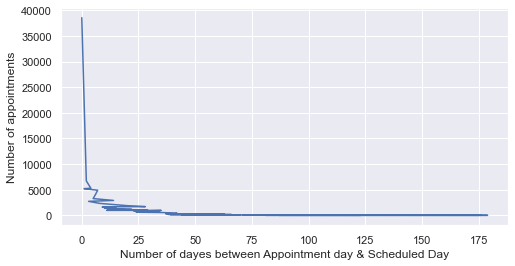

In [29]:
df.Waiting.value_counts().plot(figsize=(8, 4));
plt.xlabel('Number of dayes between Appointment day & Scheduled Day', fontsize=12);
plt.ylabel('Number of appointments', fontsize=12);

* Now there is no appointment day after its scheduled day.

In [30]:
# making 2 columns for the days of the appointment day & sceduled day.
Appointment_Day = df.AppointmentDay.dt.day_name()
df.insert(5, 'Appointment_Day', Appointment_Day)

Scheduled_Day = df.ScheduledDay.dt.day_name()
df.insert(5, 'Scheduled_Day', Scheduled_Day)

> Cleaning and Editing **No-show** column.

In [31]:
# changing the column name to be 'No_show' instead of 'NO-show'
df.rename(columns={'No-show': 'No_show'}, inplace=True)

In [32]:
# changing each No => 0 & Yes => 1
df['No_show'] = df['No_show'].apply(lambda val: 0 if val == 'No' else 1)

> Cleaning and Editign **Age** column.

In [33]:
# Ignoring any invalid ages' rows.
df = df[df['Age'] >= 0]

In [34]:
# Making ages in groubs ['0:5', '6:9', '10:17', '18:34', '35:54', '55:74', '74+']

maximum_age = df.Age.max()
labels = ['0:5', '6:9', '10:17', '18:34', '35:54', '55:74', '74+']
bins = [0, 5, 9, 17, 34, 54, 74, maximum_age]

Age_stage = pd.cut(df['Age'], bins=bins, labels=labels)
df.insert(9, 'Age_stage', Age_stage)


> Cleaning and Editing **Handcap** column.

In [35]:
# Ignoring all values that not in [0, 1]
df['Handcap'] = df.query('Handcap in [0, 1]')['Handcap']
df['Handcap'].value_counts()

0.0    108282
1.0      2040
Name: Handcap, dtype: int64

* Now there are no values in the Handcap column except 0 & 1.

<a id='eda'></a>
## Exploratory Data Analysis

### 1) What is the most days for showing up and No-showing up?

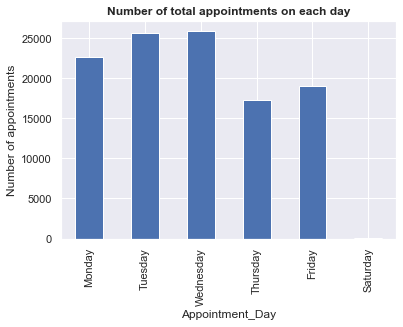

In [111]:
days_name = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

Total_appointments_inDays = df.groupby('Appointment_Day')['PatientId'].count()[days_name]

Total_appointments_inDays.plot(kind='bar')
plt.title('Number of total appointments on each day', fontweight='bold')
plt.ylabel('Number of appointments');


> The chart show us the most days the patients toke appointments in and they are in descending order:
>    1. Wednesday => 25867 appointments.
>    2. Tuesday   => 25640 appointments.
>    3. Monday    => 22714 appointments.

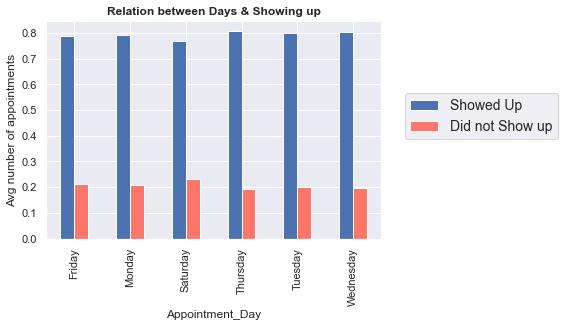

In [253]:
# We need to take propotions here too.
propotions = get_propotions('Appointment_Day', df)

propotions.unstack().plot(kind='bar', color=['b', '#FC766AFF'])
plt.legend(labels=['Showed Up', 'Did not Show up'], fontsize=14, bbox_to_anchor=(1.05, 0.7));
plt.ylabel('Avg number of appointments');
plt.title('Relation between Days & Showing up', fontsize=12, fontweight='bold');

* We notice that patients who booked an appointment on Thursday mostly showed up. The reason may be that Thursday is the weekend!
* patients who booked an appointment on Saturday, mostly didn't show up.

> But, **The Appointment Day did not  affect greatly showing up.**

### 2) Is the increase in the number of waiting days  affect the showing up?

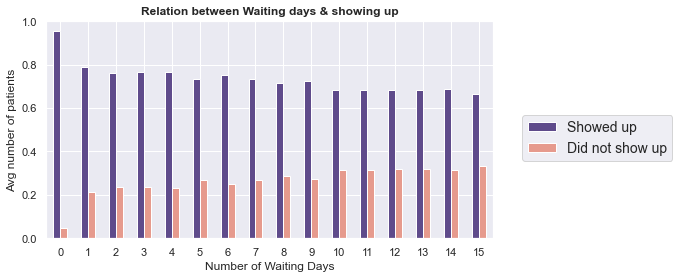

In [255]:
# to get values from 0 waiting to 15 days waiting.
normal_wait = df.query('Waiting <= 15')

propotions = get_propotions('Waiting', normal_wait)

propotions.unstack().plot(kind='bar', color= ['#5F4B8BFF', '#E69A8DFF'], figsize=(8, 4))
plt.xticks(rotation=0);
plt.legend(labels=['Showed up', 'Did not show up'], fontsize=14, bbox_to_anchor=(1.05, 0.6));
plt.xlabel('Number of Waiting Days');
plt.ylabel('Avg number of patients');
plt.title('Relation between Waiting days & showing up', fontweight='bold');

> * We notice that if patient make the appointment in the same day he call to schedule it .. he will show up.\
> * If the patient toke an appoint ment after he schedule it by 4+ days he may not showing up.

> **The increase in the number of waiting days affects badely the showing up**

### 3) Is there any relationship between showing up and the gender?

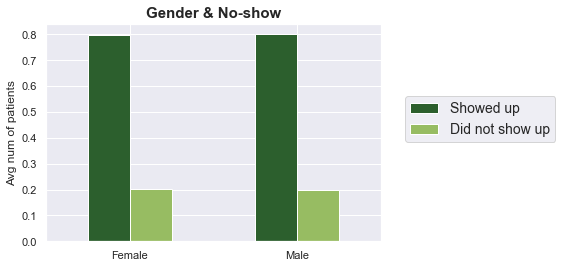

In [256]:
propotions = get_propotions('Gender', df)

PlotPropotions(propotions, 'Gender', '#2C5F2D', '#97BC62FF', 'Female', 'Male')

* As we know from assessing data on the section of gender,\
    the number of females is about the double of the number of males.\
    We will take proportions to be fair.

> We get that **Gender did not have an effect on showing up or not**.

### 4) Is there any relationship between showing up and the Age?

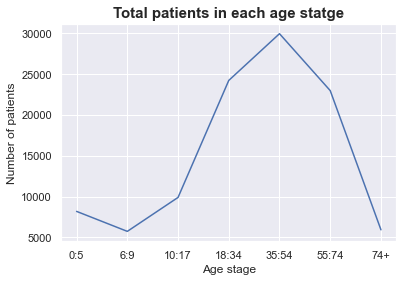

In [115]:
Total_patients_inStatges = df.groupby('Age_stage')['No_show'].count()

plt.plot(Total_patients_inStatges);
plt.title('Total patients in each age statge', fontsize=15, fontweight='bold');
plt.xlabel('Age stage', fontsize=12);
plt.ylabel('Number of patients', fontsize=12);


* We notice that the age stage that has the most number of patients is 35 to 54 years.
* Because of that change in the number of patients in each stage we will make analysis on proportions, not values.

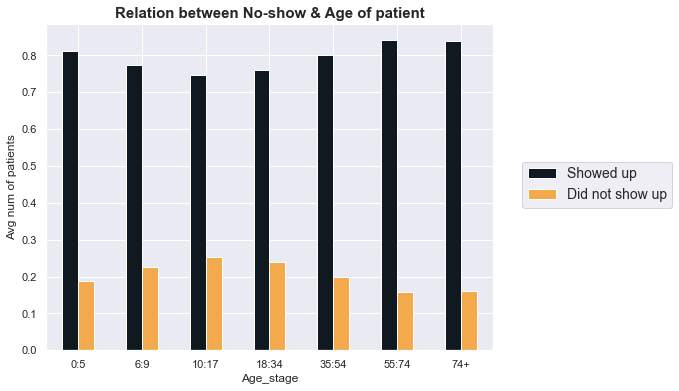

In [257]:
propotions = get_propotions('Age_stage', df)

propotions.unstack().plot.bar(color=['#101820FF', '#F2AA4CFF'], figsize=(8, 6));

plt.ylabel('Avg num of patients')
plt.title('Relation between No-show & Age of patient', fontsize=15, fontweight='bold')
plt.xticks(rotation=0);
plt.legend(labels=['Showed up', 'Did not show up'], fontsize=14, bbox_to_anchor=(1.05, 0.6));

> Most people who showed up in Descending order from the age statges:
>    1. 55 to 74 years old.
>    2. more than 74 years old.
>    3. 0 to 5 years old.
    
    
> Most people who Did not show up in Descending order from the age statges:
>    1. 10 to 17 years old.
>    2. 18 to 34 years old. 

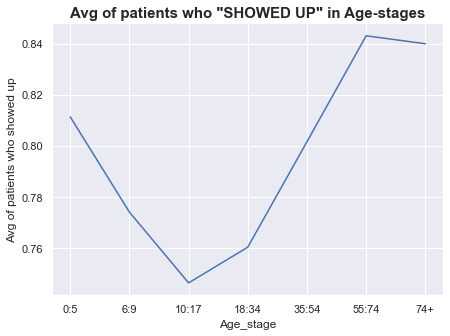

In [117]:
Total_patients_showed_inStage = df.query('No_show == 0').groupby('Age_stage')['PatientId'].count()
propotions = Total_patients_showed_inStage / Total_patients_inStatges

propotions.plot(color='b', figsize=(7, 5));
plt.title('Avg of patients who "SHOWED UP" in Age-stages', fontsize=15, fontweight='bold');
plt.ylabel('Avg of patients who showed up');

* We can notice that in the young and old age stages, attendance increases\
and decreases dramatically in the middle age stages. As we see that decrease\
from The stage 6 to 9 years till it began to increase at the stage of 35 to 54 till the end.

> **So, there is a relationship between the age stage and the showing up!**

### 5) Do Receiving messages have an effect on comming to the appointment? 


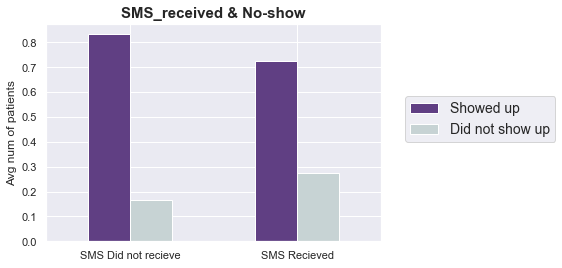

In [258]:
propotions = get_propotions('SMS_received', df)

PlotPropotions(propotions, 'SMS_received', '#603F83FF', '#C7D3D4FF', 'SMS Did not recieve', 'SMS Recieved')

> * **Patients who didn't receive the SMS showed up more than those who received it.**
> * But there are also patients who showed up however they received an SMS.
> * This may be because the SMS messages were sent to those who didn't come on their booked appointment day.
>


### 6) What is the most disease between **Hipertension** and **Diabetes** affect the absence of the patiente?

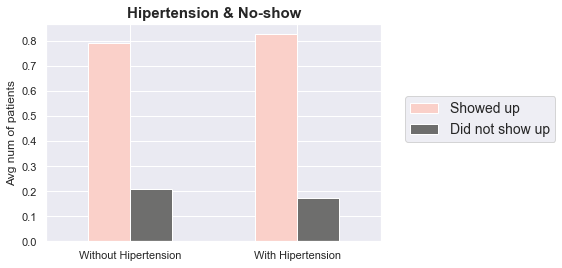

In [260]:
propotions = get_propotions('Hipertension', df)

PlotPropotions(propotions, 'Hipertension', '#FAD0C9FF', '#6E6E6DFF', 'Without Hipertension', 'With Hipertension')

* Patients who had Hipertension Showed up more than those who hadn't Hypertension but litely.

> **Hipertension Did not have a great effect on showing up or not**

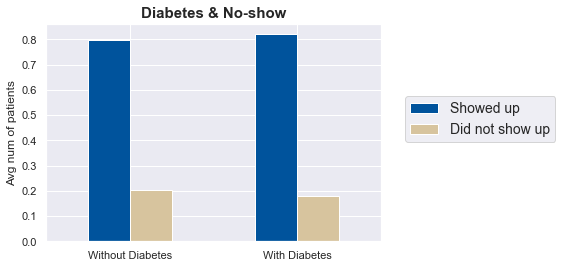

In [267]:
propotions = get_propotions('Diabetes', df)

PlotPropotions(propotions, 'Diabetes', '#00539CFF', '#D7C49EFF', 'Without Diabetes', 'With Diabetes')

* Patients who had Diabetes Showed up more than those who hadn't Diabetes but litely.

> **Diabetes Did not have a great effect on showing up or not**

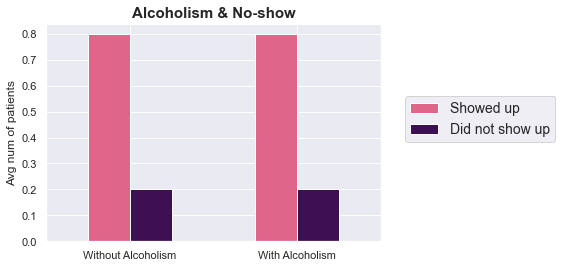

In [268]:
propotions = get_propotions('Alcoholism', df)

PlotPropotions(propotions, 'Alcoholism', '#DF6589FF', '#3C1053FF', 'Without Alcoholism', 'With Alcoholism')

> We can see that **Alcoholism did not have any effect on showing up or not.**

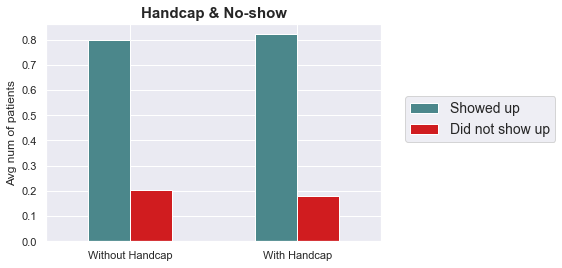

In [270]:
propotions = get_propotions('Handcap', df)

PlotPropotions(propotions, 'Handcap', '#4B878BFF', '#D01C1FFF', 'Without Handcap', 'With Handcap')

* Patients who had Handcap Showed up more than those who hadn't Diabetes but litely.

> **Handcap Did not have a great effect on showing up or not**

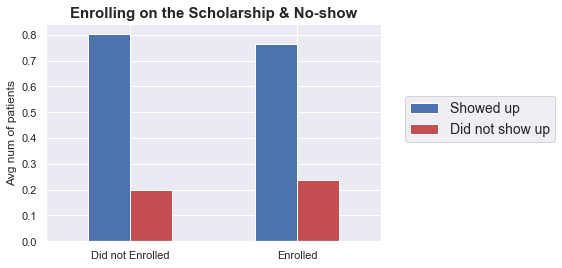

In [186]:
propotions = get_propotions('Scholarship', df)

PlotPropotions(propotions, 'Enrolling on the Scholarship', 'b', 'r', 'Did not Enrolled', 'Enrolled')

> **Patients who did not enroll** in the Brasilian welfare program Bolsa Família **showed up** more than those who enrolled in it.

### 5) What are the hospitals with the maximum proportion of showing up?

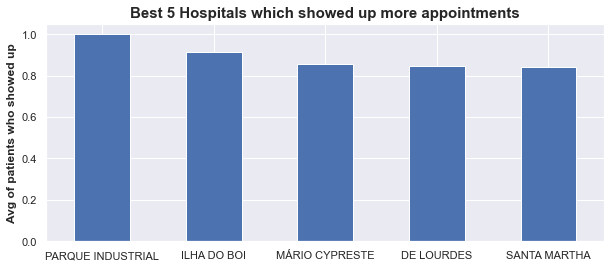

In [248]:
propotions = get_propotions('Neighbourhood', df)
Best5 = propotions.sort_values(ascending=False)[0:10:2]

Best5.unstack().plot(kind='bar', legend=False, figsize=(10, 4))
# propotions.plot(color='b', figsize=(7, 5));
plt.title('Best 5 Hospitals which showed up more appointments', fontsize=15, fontweight='bold');
plt.ylabel('Avg of patients who showed up', fontweight='bold');
plt.xticks(rotation=0);
plt.xlabel('');

* We notice that the most 2 hospitals with the maximum proportion of showing up are:
    1. PARQUE INDUSTRIA.
    2. ILHA DO BOI
    
* The reason maybe they are the nearest hospitals for the majority of the patients.

<a id='conclusions'></a>
## Conclusions

